In [ ]:
!pip install -q datasets transformers seqeval evaluate accelerate fsspec==2023.9.2
!pip install --upgrade --no-cache-dir datasets


In [ ]:
!pip install --upgrade --no-cache-dir transformers

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

# LoRA integration
from peft import get_peft_model, LoraConfig, TaskType
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = load_dataset("wikiann", "fr")

label_list = dataset["train"].features["ner_tags"].feature.names
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}
print(label_list)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


In [ ]:
model_checkpoint = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
base_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Apply LoRA configuration to the output dense layers
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["output.dense"],
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()


# %%
seqeval = evaluate.load("seqeval")

trainable params: 521,479 || all params: 110,558,222 || trainable%: 0.4717


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [ ]:
import transformers
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    report_to="none",
    output_dir="./french_ner_model",
    eval_strategy="epoch",                 # <- This is correct
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


<ipython-input-10-1373c253ebb1>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.021200,0.951618,0.369571,0.460474,0.410045,0.720009
2,0.647200,0.606518,0.566313,0.686455,0.620623,0.853401
3,0.477700,0.423085,0.729187,0.792262,0.759417,0.899736
4,0.415500,0.351165,0.765202,0.813013,0.788384,0.906508
5,0.343800,0.312970,0.784874,0.826695,0.805242,0.913105
6,0.308800,0.290199,0.802453,0.840453,0.821014,0.919437
7,0.287600,0.280628,0.804262,0.840453,0.821960,0.919422
8,0.287800,0.269154,0.810492,0.845546,0.827648,0.922134
9,0.256500,0.263858,0.815950,0.851551,0.833371,0.925095
10,0.282100,0.256409,0.819288,0.854971,0.836749,0.926605


TrainOutput(global_step=56250, training_loss=0.27917152130126954, metrics={'train_runtime': 2897.1964, 'train_samples_per_second': 345.161, 'train_steps_per_second': 21.573, 'total_flos': 1.421471087485152e+16, 'train_loss': 0.27917152130126954, 'epoch': 45.0})

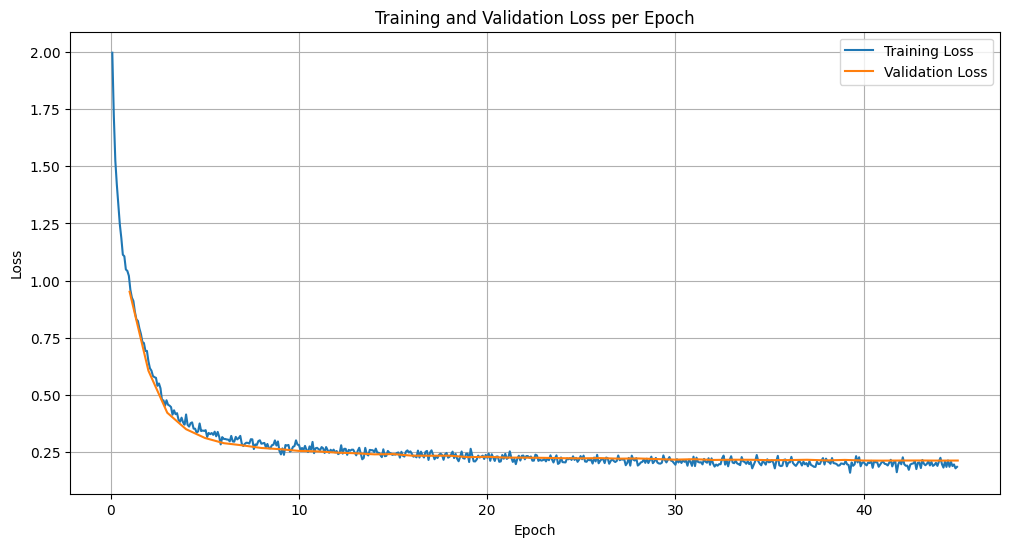

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the training log
log_history = trainer.state.log_history

# Collect training loss and evaluation loss per epoch
train_loss = [entry["loss"] for entry in log_history if "loss" in entry and "epoch" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry and "epoch" in entry]
epochs_train = [entry["epoch"] for entry in log_history if "loss" in entry and "epoch" in entry]
epochs_eval = [entry["epoch"] for entry in log_history if "eval_loss" in entry and "epoch" in entry]

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(epochs_train, train_loss, label="Training Loss")
plt.plot(epochs_eval, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


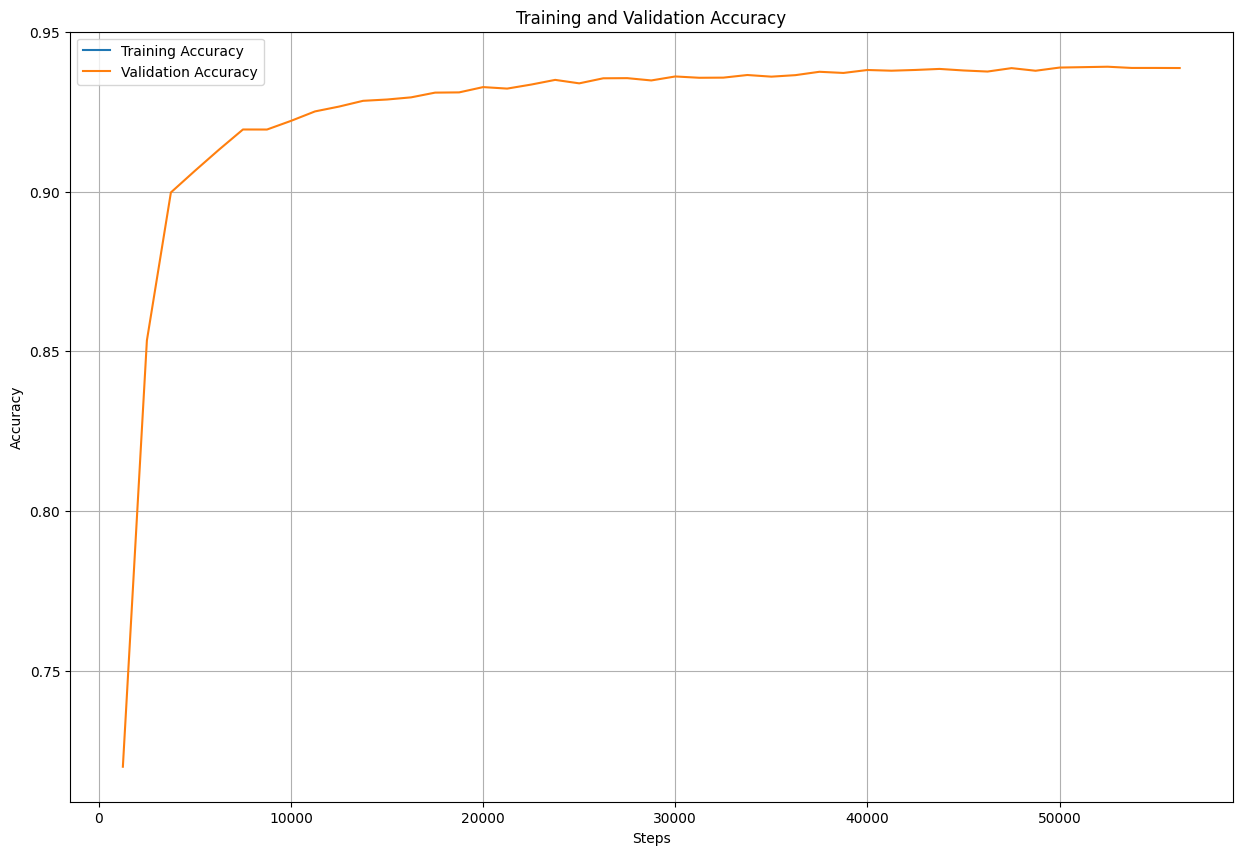

In [ ]:
import matplotlib.pyplot as plt

# Log history from training
log_history = trainer.state.log_history

# Extract training and validation accuracy entries
train_acc = [entry["accuracy"] for entry in log_history if "accuracy" in entry and "eval_" not in entry]
eval_acc = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]
steps_train = [entry["step"] for entry in log_history if "accuracy" in entry and "eval_" not in entry]
steps_eval = [entry["step"] for entry in log_history if "eval_accuracy" in entry]

# Plot
plt.figure(figsize=(15, 10))
plt.plot(steps_train, train_acc, label="Training Accuracy")
plt.plot(steps_eval, eval_acc, label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Evaluating training accuracy per epoch...


  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 1/45 [00:00<00:28,  1.55it/s]

  4%|▍         | 2/45 [00:01<00:27,  1.58it/s]

  7%|▋         | 3/45 [00:01<00:26,  1.57it/s]

  9%|▉         | 4/45 [00:02<00:25,  1.60it/s]

 11%|█         | 5/45 [00:03<00:24,  1.64it/s]

 13%|█▎        | 6/45 [00:03<00:23,  1.66it/s]

 16%|█▌        | 7/45 [00:04<00:22,  1.66it/s]

 18%|█▊        | 8/45 [00:04<00:22,  1.65it/s]

 20%|██        | 9/45 [00:05<00:21,  1.68it/s]

 22%|██▏       | 10/45 [00:06<00:20,  1.68it/s]

 24%|██▍       | 11/45 [00:06<00:21,  1.61it/s]

 27%|██▋       | 12/45 [00:07<00:20,  1.63it/s]

 29%|██▉       | 13/45 [00:07<00:19,  1.65it/s]

 31%|███       | 14/45 [00:08<00:18,  1.65it/s]

 33%|███▎      | 15/45 [00:09<00:18,  1.65it/s]

 36%|███▌      | 16/45 [00:09<00:17,  1.62it/s]

 38%|███▊      | 17/45 [00:10<00:16,  1.65it/s]

 40%|████      | 18/45 [00:10<00:16,  1.68it/s]

 42%|████▏     | 19/45 [00:11<00:15,  1.71it/s]

 44%|████▍     | 20/45 [00:12<00:14,  1.73it/s]

 47%|████▋     | 21/45 [00:12<00:13,  1.72it/s]

 49%|████▉     | 22/45 [00:13<00:13,  1.73it/s]

 51%|█████     | 23/45 [00:14<00:14,  1.54it/s]

 53%|█████▎    | 24/45 [00:14<00:13,  1.59it/s]

 56%|█████▌    | 25/45 [00:15<00:12,  1.62it/s]

 58%|█████▊    | 26/45 [00:15<00:11,  1.64it/s]

 60%|██████    | 27/45 [00:16<00:10,  1.68it/s]

 62%|██████▏   | 28/45 [00:16<00:09,  1.70it/s]

 64%|██████▍   | 29/45 [00:17<00:09,  1.71it/s]

 67%|██████▋   | 30/45 [00:18<00:08,  1.72it/s]

 69%|██████▉   | 31/45 [00:18<00:08,  1.71it/s]

 71%|███████   | 32/45 [00:19<00:07,  1.70it/s]

 73%|███████▎  | 33/45 [00:19<00:07,  1.69it/s]

 76%|███████▌  | 34/45 [00:20<00:06,  1.70it/s]

 78%|███████▊  | 35/45 [00:21<00:05,  1.71it/s]

 80%|████████  | 36/45 [00:21<00:05,  1.69it/s]

 82%|████████▏ | 37/45 [00:22<00:04,  1.71it/s]

 84%|████████▍ | 38/45 [00:22<00:04,  1.72it/s]

 87%|████████▋ | 39/45 [00:23<00:03,  1.71it/s]

 89%|████████▉ | 40/45 [00:23<00:02,  1.71it/s]

 91%|█████████ | 41/45 [00:24<00:02,  1.72it/s]

 93%|█████████▎| 42/45 [00:25<00:01,  1.72it/s]

 96%|█████████▌| 43/45 [00:25<00:01,  1.71it/s]

 98%|█████████▊| 44/45 [00:26<00:00,  1.69it/s]

100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


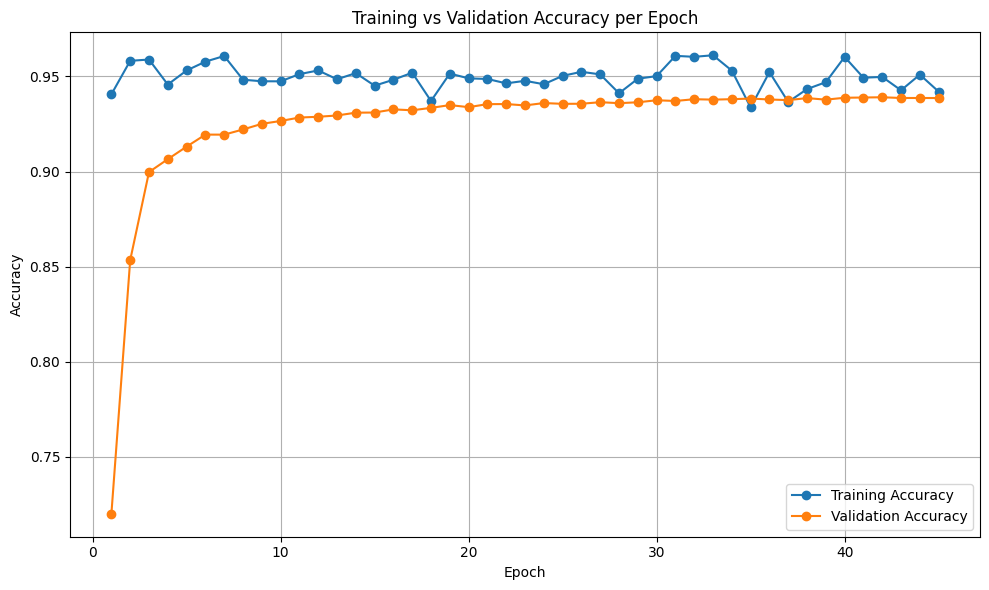

In [ ]:
import matplotlib.pyplot as plt
from transformers import EvalPrediction
import numpy as np
import torch
from tqdm import tqdm

# Helper: split dataset by epoch based on training size
def split_dataset_by_epoch(dataset, num_epochs):
    dataset_size = len(dataset)
    size_per_epoch = dataset_size // num_epochs
    return [dataset.select(range(i * size_per_epoch, (i + 1) * size_per_epoch)) for i in range(num_epochs)]

# Load log history
log_history = trainer.state.log_history
num_epochs = int(max(entry["epoch"] for entry in log_history if "epoch" in entry))

# Extract validation accuracy per epoch
val_acc = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]
epochs = list(range(1, len(val_acc) + 1))

# Evaluate training accuracy per epoch (by slicing the training set)
train_epoch_datasets = split_dataset_by_epoch(tokenized_datasets["train"], num_epochs)
train_acc = []

print("Evaluating training accuracy per epoch...")

for epoch_ds in tqdm(train_epoch_datasets):
    preds = trainer.predict(epoch_ds)
    acc = compute_metrics(EvalPrediction(predictions=preds.predictions, label_ids=preds.label_ids))["accuracy"]
    train_acc.append(acc)

min_len = min(len(epochs), len(train_acc), len(val_acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs[:min_len], train_acc[:min_len], marker='o', label="Training Accuracy")
plt.plot(epochs[:min_len], val_acc[:min_len], marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
model.save_pretrained("./french_ner_modelV3")
tokenizer.save_pretrained("./french_ner_modelV3")

('./french_ner_modelV3/tokenizer_config.json',
 './french_ner_modelV3/special_tokens_map.json',
 './french_ner_modelV3/sentencepiece.bpe.model',
 './french_ner_modelV3/added_tokens.json',
 './french_ner_modelV3/tokenizer.json')

In [ ]:
import shutil
shutil.make_archive("french_ner_modelV3", 'zip', "./french_ner_modelV3")

'/content/french_ner_modelV3.zip'

In [ ]:
from google.colab import files
files.download("french_ner_modelV3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
predictions = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions.predictions, axis=2)
labels = predictions.label_ids


In [ ]:
true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_preds.append(label_list[p])
            true_labels.append(label_list[l])


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, true_preds, digits=4))


              precision    recall  f1-score   support

       B-LOC     0.9098    0.9236    0.9166      4840
       B-ORG     0.8624    0.8652    0.8638      3910
       B-PER     0.9363    0.9335    0.9349      4406
       I-LOC     0.8981    0.8672    0.8824      5986
       I-ORG     0.8825    0.9073    0.8948     10491
       I-PER     0.9305    0.8924    0.9110      6420
           O     0.9811    0.9842    0.9827     32167

    accuracy                         0.9391     68220
   macro avg     0.9144    0.9105    0.9123     68220
weighted avg     0.9392    0.9391    0.9390     68220



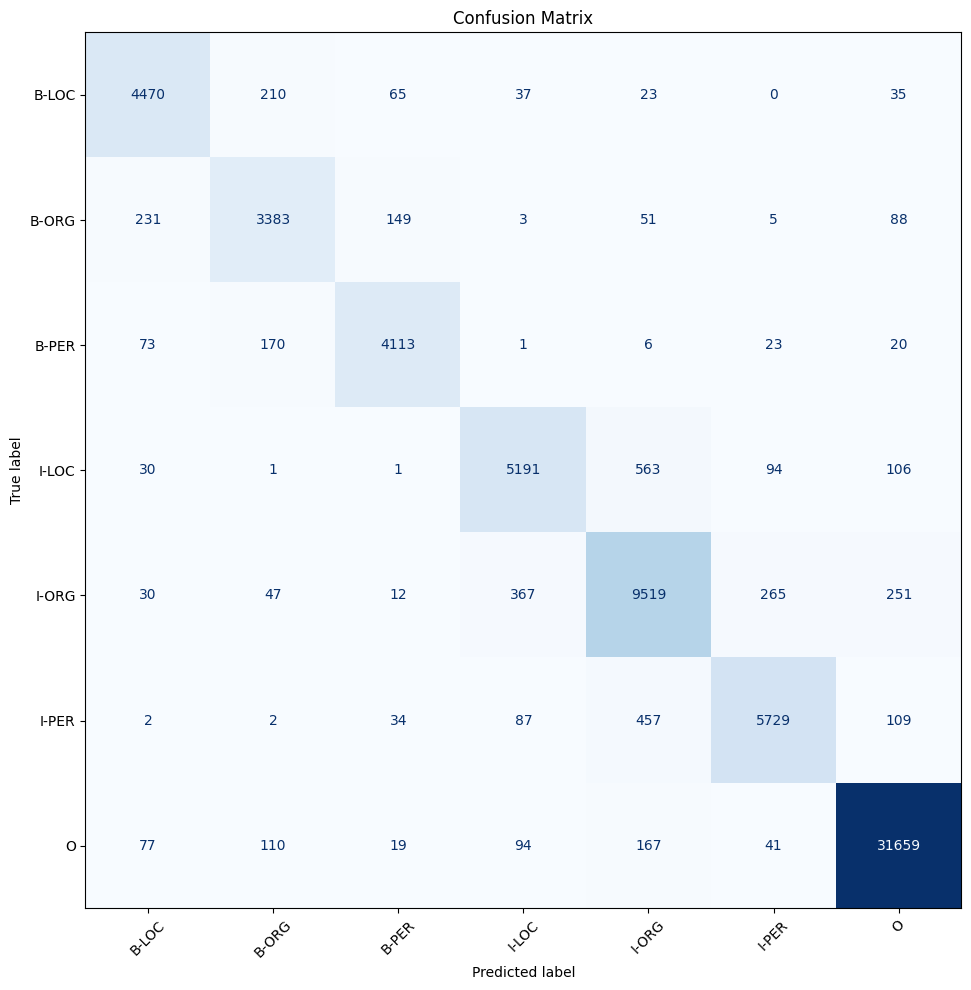

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

labels_unique = sorted(list(set(true_labels + true_preds)))
cm = confusion_matrix(true_labels, true_preds, labels=labels_unique)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_unique)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
